## DQN Tutorial

In [1]:
%matplotlib inline

In [2]:
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from collections import namedtuple
from itertools import count

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [5]:
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Bit flipping environment

In [6]:
class BitFlipEnv():
    
    def __init__(self, n = 8):
        self.n = n
        self.init_state = torch.randint(2, size=(n,))
        self.target_state = torch.randint(2, size=(n,))
        while np.array_equal(self.init_state, self.target_state):
            self.target_state = torch.randint(2, size=(n,))
        self.curr_state = self.init_state.clone()
        
    def step(self, action):
        self.curr_state[action] = 1 - self.curr_state[action]
        if np.array_equal(self.curr_state, self.target_state):
            return self.curr_state.clone(), 0
        else:
            return self.curr_state.clone(), -1
        
    def reset(self):
        self.init_state = torch.randint(2, size=(self.n,))
        self.target_state = torch.randint(2, size=(self.n,))
        while np.array_equal(self.init_state, self.target_state):
            self.target_state = torch.randint(2, size=(self.n,))
        self.curr_state = self.init_state.clone()

In [7]:
env = BitFlipEnv(n=10)

In [8]:
print('Initial state:', env.init_state)
print('Target state:', env.target_state)
curr_state, reward = env.step(9)
print('State, reward after taking action 9:', curr_state, reward)
print(type(curr_state))
env.reset()

Initial state: tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.])
Target state: tensor([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.])
State, reward after taking action 9: tensor([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]) -1
<class 'torch.Tensor'>


## Replay Memory

In [9]:
Transition = namedtuple('Transition', 
                       ('state', 'action', 'next_state', 'reward', 'goal'))

class ReplayMemory(object):
    
    def __init__(self, capacity = 1e5):
        self.capacity = capacity
        self.memory = []
    
    def push(self, *args):
        """Saves a transition which should contain:
        - current state
        - action taken
        - next state
        - reward obtained
        - goal state"""
        self.memory.append(Transition(*args))
        if len(self.memory) > self.capacity:
            print('!!!!!memory capacity exceeded!')
            del self.memory[0]

    def sample(self, batch_size):
        """
        Returns batch_size number of samples from the replay memory
        """
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return len(self.memory)

In [10]:
# replay = ReplayMemory(2)
# print(replay.capacity)
# replay.push(curr_state, 9, curr_state, 0, curr_state)
# print(len(replay))
# print(replay.memory)
# curr_state, reward = env.step(9)
# replay.push(curr_state, 9, curr_state, 1, curr_state)
# print(len(replay))
# print(replay.memory)
# curr_state, reward = env.step(1)
# replay.push(curr_state, 1, curr_state, 2, curr_state)
# print(len(replay))
# print(replay.memory)

# batch = Transition(*zip(*replay.sample(2)))
# print(batch.reward)
# batch_e = torch.cat(batch.reward)
# batch_e

## Q-Network in pytorch

In [11]:
class DQN(nn.Module):
    
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)
        self.head = nn.Linear(448, 2)
        
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        return self.head(x.view(x.size(0), -1))

## Feedforward network

In [12]:
NUM_BITS = 7
HIDDEN_SIZE = 256 

In [13]:
class FNN(nn.Module):
    
    def __init__(self):
        super(FNN, self).__init__()
        self.ln1 = nn.Linear(NUM_BITS*2, HIDDEN_SIZE)
        self.ln2 = nn.Linear(HIDDEN_SIZE, NUM_BITS)
        
    def forward(self, x):
        x = F.relu(self.ln1(x))
        x = self.ln2(x)
        return x
    

## Hyper parameters

In [14]:
BATCH_SIZE = 128
GAMMA = 0.999
EPS_START = 0.95
EPS_END = 0.05

TARGET_UPDATE = 10
MODEL_PATH = '_her_policy_net.pt'
WEIGHTS_PATH = '_her_policy_net_weights.pt'
SAVE_MODEL = True
steps_done = 0

## Initialize Model

In [15]:
policy_net = FNN().to(device)
target_net = FNN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())
memory = ReplayMemory(1e6)

## Helper functions

In [16]:
def select_action(state, goal, greedy=False):
    global steps_done
    sample = random.random()
    state_goal = torch.cat((state, goal))
#     print(state)
#     print(goal)
#     print(state_goal)
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if steps_done % 5000 == 0:
        print('Steps done: {} Epsilon threshold: {}'.format(steps_done, eps_threshold))
    if greedy:
        with torch.no_grad():
            return policy_net(state_goal).argmax().view(1,1)
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state_goal).argmax().view(1,1)
    else: 
        return torch.tensor([[random.randrange(NUM_BITS)]], device=device, dtype=torch.long)

In [18]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
#     print(transitions)
    batch = Transition(*zip(*transitions))
#     print(batch)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, 
                                           batch.next_state)), device=device, dtype=torch.uint8)
    non_final_next_states = torch.stack([s for s in batch.next_state 
                                      if s is not None])
    
    
    state_batch = torch.stack(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    goal_batch = torch.stack(batch.goal)
    state_goal_batch = torch.cat((state_batch, goal_batch), 1)
    non_final_next_states_goal = torch.cat((non_final_next_states, goal_batch), 1)
    
    state_action_values = policy_net(state_goal_batch).gather(1, action_batch)
    
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states_goal).max(1)[0].detach()
    
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch.float()
    
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()

In [19]:
HindsightTransition = namedtuple('HindsightTransition', 
                       ('state', 'action', 'next_state', 'reward'))

In [20]:
CHECK_RATE = 500

In [21]:
num_episodes = 15000
EPS_DECAY = num_episodes * NUM_BITS * 0.25
env = BitFlipEnv(NUM_BITS)
success = 0
episodes = []
success_rate = []
for i_episode in range(num_episodes):
    env.reset()
    state = env.init_state
    goal = env.target_state
    transitions = []
    episode_success = False
    for t in range(NUM_BITS):
        if episode_success:
            continue
        action = select_action(state, goal)
        next_state, reward = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        
        memory.push(state, action, next_state, reward, goal)
        
        transitions.append(HindsightTransition(state, action, next_state, reward))

        state = next_state
        
        optimize_model()
        if reward == 0:
            if episode_success:
                continue
            else:
                episode_success = True
                success += 1
    if not episode_success:
        new_goal_state = state.clone()
#         print('Hindsight experience')
        if not np.array_equal(new_goal_state, goal):
            for i in range(NUM_BITS):
                if np.array_equal(transitions[i].next_state, new_goal_state):
                    memory.push(transitions[i].state, transitions[i].action, transitions[i].next_state, torch.tensor([0]), new_goal_state)
                    optimize_model()
                    break

                memory.push(transitions[i].state, transitions[i].action, transitions[i].next_state, transitions[i].reward, new_goal_state)
                optimize_model()

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())
#         print(i_episode, end=' ')
    if i_episode % CHECK_RATE == 0:
        print('success rate for last {} episodes after {} episodes of training: {}%'.format(CHECK_RATE, i_episode, success/CHECK_RATE * 100))
        success_rate.append(success/CHECK_RATE)
        episodes.append(i_episode)
        success = 0

# print('\nTotal episodes succeeeded', success)
## save weights
             

success rate for last 500 episodes after 0 episodes of training: 0.0%
success rate for last 500 episodes after 500 episodes of training: 7.199999999999999%
Steps done: 5000 Epsilon threshold: 0.830212401239605
success rate for last 500 episodes after 1000 episodes of training: 14.799999999999999%
success rate for last 500 episodes after 1500 episodes of training: 19.6%
Steps done: 10000 Epsilon threshold: 0.7263488877456348
success rate for last 500 episodes after 2000 episodes of training: 26.8%
Steps done: 15000 Epsilon threshold: 0.6363119033073072
success rate for last 500 episodes after 2500 episodes of training: 31.4%
success rate for last 500 episodes after 3000 episodes of training: 37.8%
Steps done: 20000 Epsilon threshold: 0.5582608313375701
success rate for last 500 episodes after 3500 episodes of training: 43.0%
success rate for last 500 episodes after 4000 episodes of training: 40.400000000000006%
Steps done: 25000 Epsilon threshold: 0.490600081995194
success rate for last

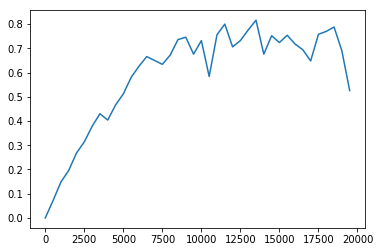

In [22]:
plt.plot(episodes, success_rate)
plt.show()

In [24]:
if SAVE_MODEL:
    torch.save(policy_net.state_dict(), str(NUM_BITS)+WEIGHTS_PATH)
    print('Weights saved')
    torch.save(policy_net, str(NUM_BITS)+MODEL_PATH)
    print('Model saved')

print('Complete')  

Weights saved
Model saved
Complete


/afs/inf.ed.ac.uk/user/s17/s1791387/miniconda3/envs/her/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
successes = 0
for i in range(10000):
    env.reset()
    test_state = env.init_state
    goal_state = env.target_state
#     print('#############################################')
#     print('start', test_state)
#     print('goal', goal_state)
    next_state = test_state.clone()
    for i in range(NUM_BITS):
        action = select_action(next_state, goal_state, greedy=True)
        next_state, reward = env.step(action.item())
#         print('taking action', action)
#         print('next state', next_state)
        if np.array_equal(next_state, goal_state):
            successes += 1
            break
print(successes)

Steps done: 105000 Epsilon threshold: 0.09480964178826774
Steps done: 110000 Epsilon threshold: 0.08884448816197152
Steps done: 115000 Epsilon threshold: 0.08367342831472066
Steps done: 120000 Epsilon threshold: 0.07919075081485333
Steps done: 125000 Epsilon threshold: 0.07530481675851096
Steps done: 130000 Epsilon threshold: 0.07193618640518118
Steps done: 135000 Epsilon threshold: 0.06901599519945195
Steps done: 140000 Epsilon threshold: 0.06648454598016044
Steps done: 145000 Epsilon threshold: 0.06429008859761678
Steps done: 150000 Epsilon threshold: 0.06238776199074606
6599
